In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from maritime_traffic_network import MaritimeTrafficNetwork
import folium
import warnings
import sys
warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

['/Users/janhendrikwebert/maritime_route_prediction/src/models', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python311.zip', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/lib-dynload', '', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/site-packages', '../visualization', '../features']
Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../visualization')
print(sys.path)

# import modules
import visualize

['/Users/janhendrikwebert/maritime_route_prediction/src/models', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python311.zip', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/lib-dynload', '', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/site-packages', '../visualization', '../features', '../visualization']


In [3]:
# read data from file
filename = '../../data/processed/202204_points_stavanger_cleaned_meta_500k.parquet'
#filename = '../../data/processed/202204_points_stavanger_cleaned_meta_full.parquet'
gdf = gpd.read_parquet(filename)

In [4]:
# Transform to desired CRS
# 4326 for WGS 84 (global) // 32632 for UTM 32N (Norway)
crs = 32632  # Coordinate reference system
gdf.to_crs(crs, inplace=True)  # Transformation
gdf.head()

,mmsi,imo_nr,length,lon,lat,sog,cog,true_heading,nav_status,message_nr,bredde,dypgaaende,skipstype,skipsgruppe,fartoynavn,geometry,speed
date_time_utc,,,,,,,,,,,,,,,,,
2022-04-01 06:30:21,209989000_0,9235505,90,4.62360,59.5881,10.0,167.2,174,0,1,13.6,6.36,General Cargo Ship,Last,LISA,POINT (252983.773 6613682.119),4.473722
2022-04-01 06:30:31,209989000_0,9235505,90,4.62367,59.5877,9.7,179.6,174,0,1,13.6,6.36,General Cargo Ship,Last,LISA,POINT (252984.785 6613637.378),4.473722
2022-04-01 06:30:40,209989000_0,9235505,90,4.62375,59.5873,9.9,173.0,174,0,1,13.6,6.36,General Cargo Ship,Last,LISA,POINT (252986.360 6613592.599),4.976744
2022-04-01 06:30:50,209989000_0,9235505,90,4.62384,59.5868,9.8,174.7,174,0,1,13.6,6.36,General Cargo Ship,Last,LISA,POINT (252987.766 6613536.663),5.593419
2022-04-01 06:31:10,209989000_0,9235505,90,4.62402,59.5859,9.7,177.4,174,0,1,13.6,6.36,General Cargo Ship,Last,LISA,POINT (252991.311 6613435.911),5.038954


In [5]:
# initialize maritime traffic network
network = MaritimeTrafficNetwork(gdf, crs)
network.get_trajectories_info()

Number of AIS messages: 483430
Number of trajectories: 617
Coordinate Reference System (CRS): EPSG:32632


In [6]:
# calculate significant turning points using Douglas Peucker algorithm
mode = 'comp'  # in 'load' mode, the calculation is skipped and stored significant turning points are loaded from file
if mode == 'load':
    filename = '../../data/processed/202204_significant_points_DP10_stavanger_500k_UTM.parquet'
    precomputed = gpd.read_parquet(filename)
    network.init_precomputed_significant_points(precomputed)
else:
    tolerance = 10 # DP tolerance parameter 0.0002
    network.calc_significant_points_DP(tolerance)

Calculating significant turning points with Douglas Peucker algorithm (tolerance = 10) ...
Number of significant points detected: 34458 (7.13% of AIS messages)
Time elapsed: 0.41 minutes
Adding course over ground before and after each turn ...
Done. Time elapsed: 0.06 minutes


In [7]:
# detect waypoints using spatial clustering
method = 'HDBSCAN'      # 'DBSCAN' , 'HDBSCAN', 'OPTICS'
metric = 'mahalanobis'  # 'euclidean', 'mahalanobis', 'haversine'
min_samples = 10
min_cluster_size = 10
eps = 0.02
V = np.diag([1, 1, 0.1, 0.1])  # mahalanobis distance parameter matrix V = np.diag([0.01, 0.01, 1e6, 1e6]) 
network.calc_waypoints_clustering(method=method, min_samples=min_samples, min_cluster_size=min_cluster_size,
                                  eps=eps, metric=metric, V=V)

Calculating waypoints with HDBSCAN (min_samples = 10) ...
Distance metric: mahalanobis
634 clusters detected
Time elapsed: 0.21 minutes


In [8]:
network.make_graph_from_waypoints(min_passages=3)

Constructing maritime traffic network graph from waypoints and trajectories...
Number of nodes: 634
Number of edges: 930
Time elapsed: 0.13 minutes



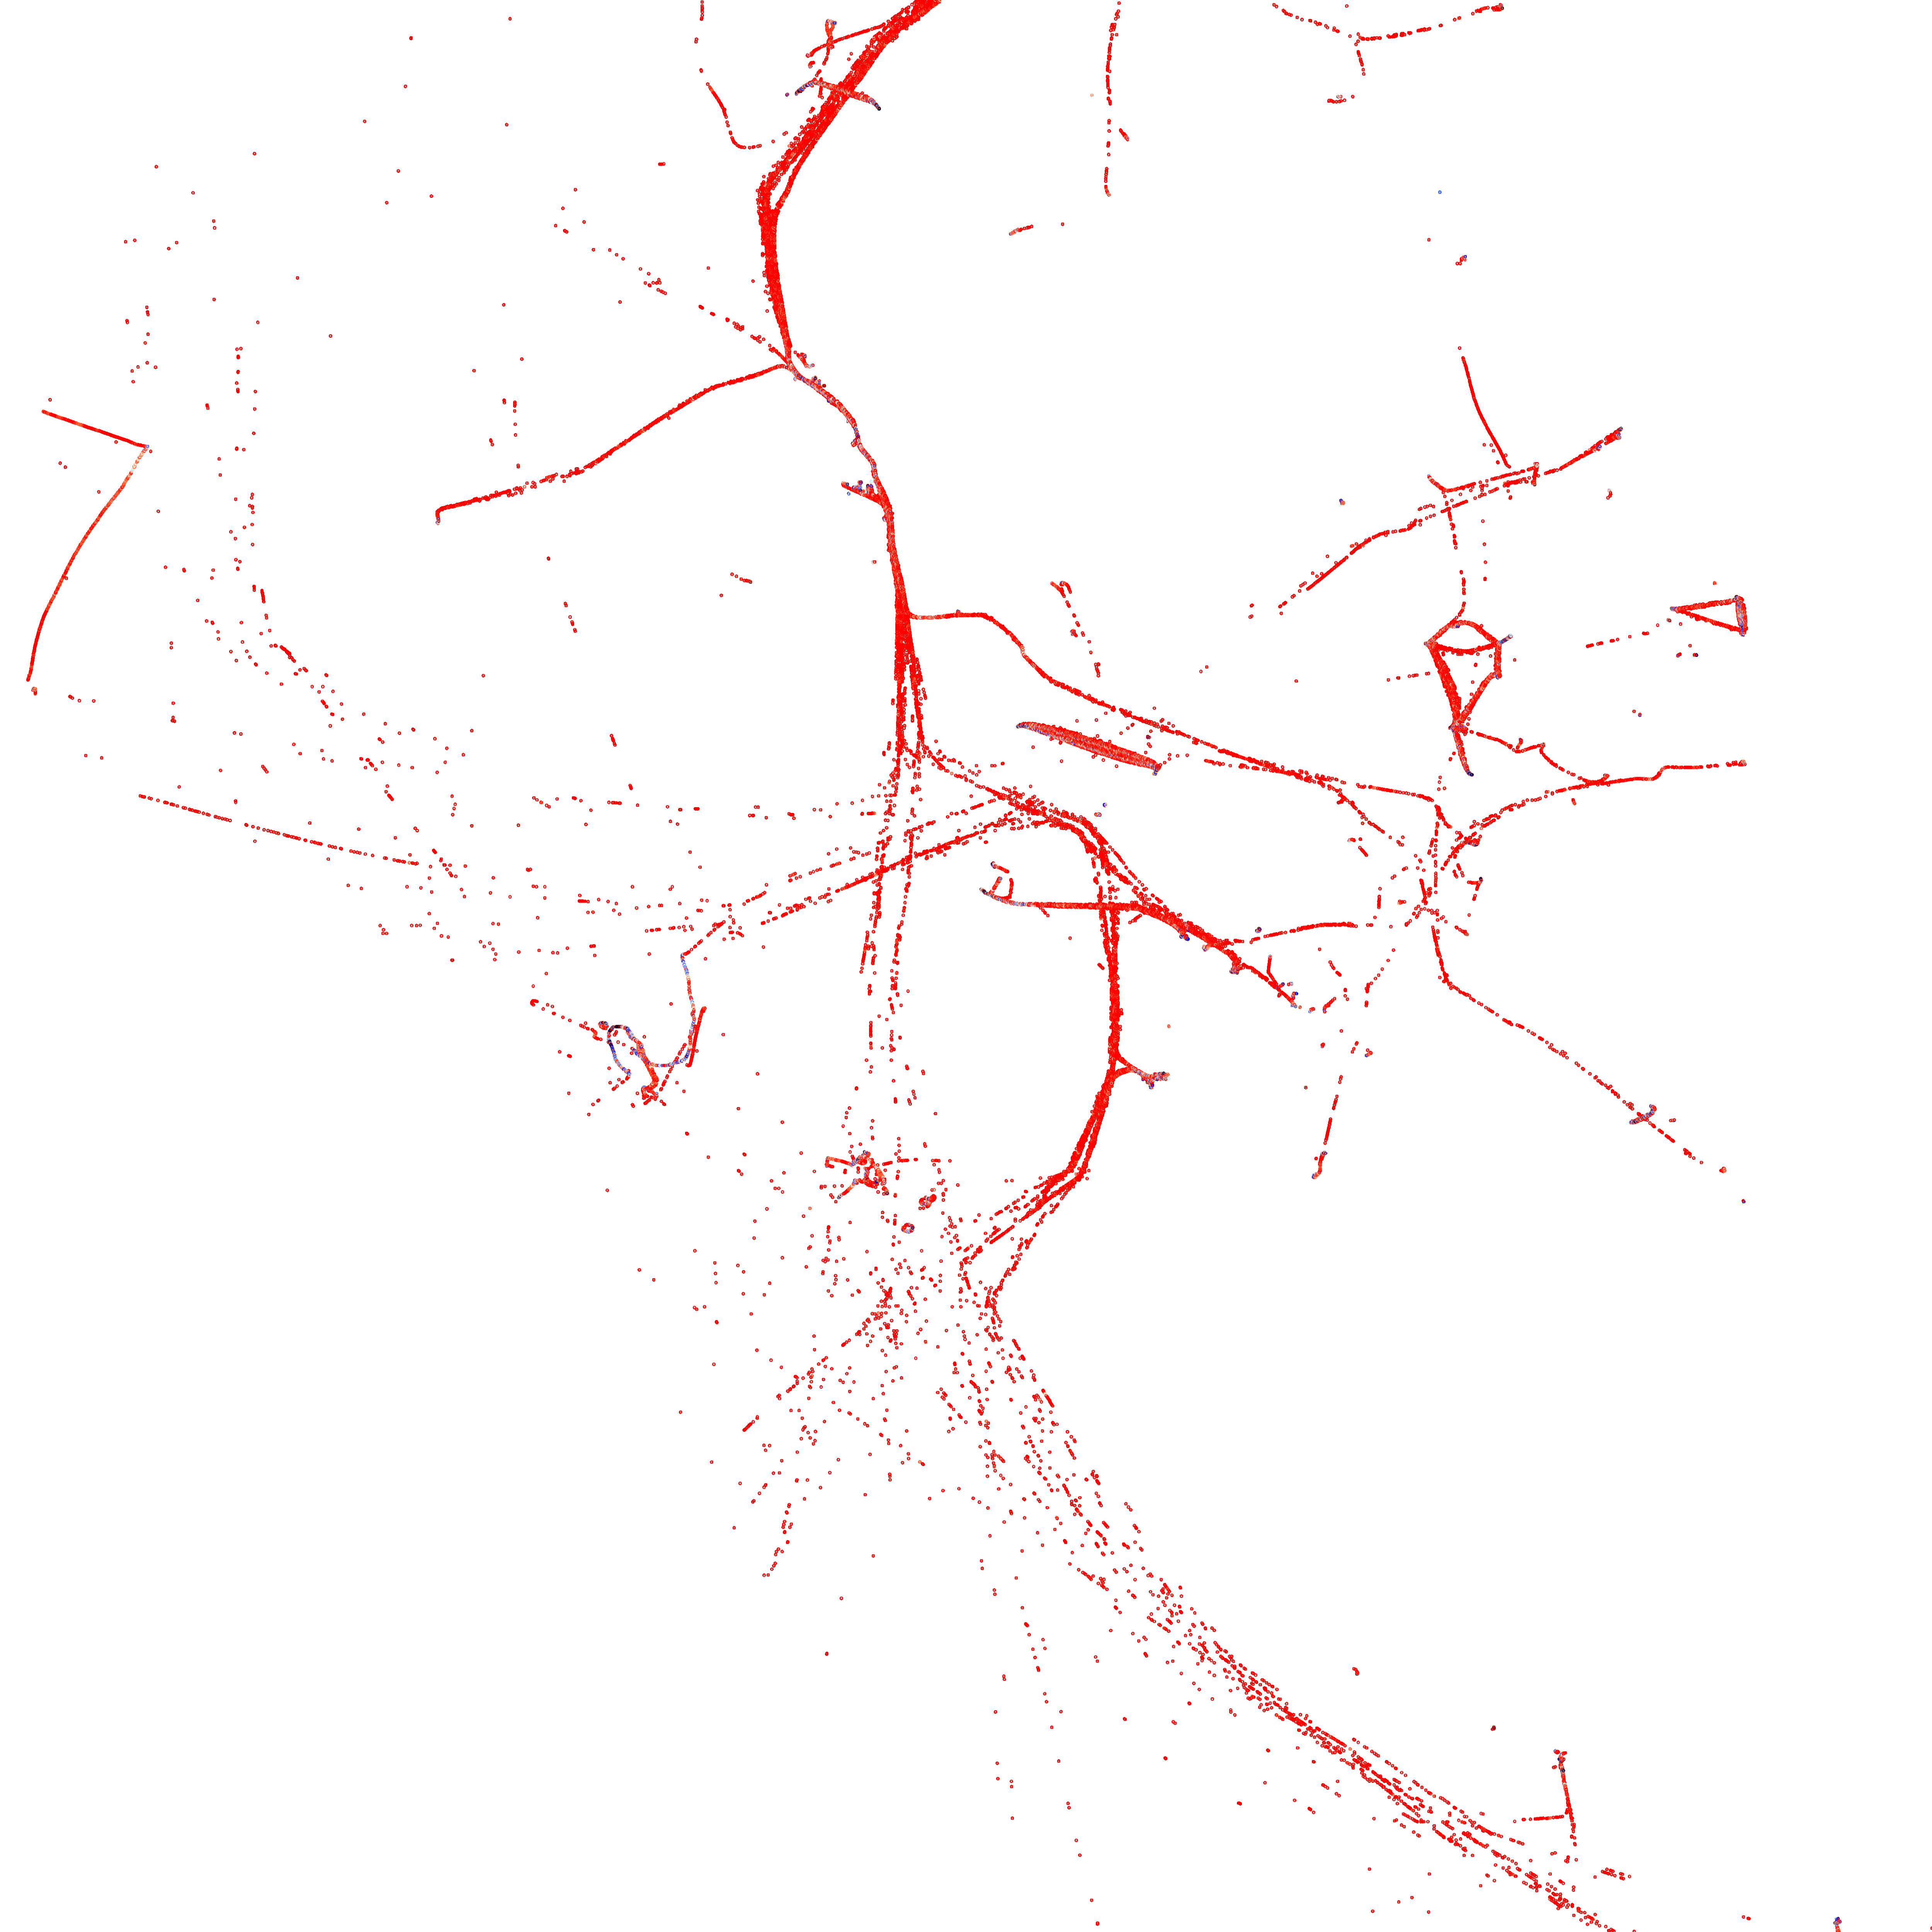

In [9]:
# Generate plot
map = network.map_graph()
folium.LayerControl().add_to(map)

# add a title
title = f'{method} parameters: min_samples = {min_samples}, metric = {metric}'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title)   

map.get_root().html.add_child(folium.Element(title_html))

map

In [10]:
#map.save('202204_waypoints_DP10_HDBSCAN10_stavanger_2M_UTM.html')

In [11]:
#data = network.significant_points.drop('clusterID', axis=1)
#data.to_parquet('../../data/processed/202204_significant_points_DP10_stavanger_2M_UTM.parquet')

In [12]:
#network.significant_points.to_parquet('../../data/processed/202204_significant_points_DP10_clustered_stavanger_2M_UTM.parquet')

In [13]:
#cluster_centroids = network.waypoints
#cluster_centroids.set_geometry('convex_hull', inplace=True, crs=crs)
#cluster_centroids.to_parquet('../../data/processed/202204_waypoints_DP10_HDBSCAN10_stavanger_2M_UTM.parquet')